In [1]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from src.model.classifier import Classifier
from src.xbox2_specific.datasets.XBOX2_trend_all_bd_20ms import XBOX2TrendAllBD20msSelect
from src.dataset_creator import load_dataset, data_array_to_numpy
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer

# Load Dataset
To load a dataset the dataset name and path to data has to be supplied.
This information is then passed to the `load_dataset` function which returns training, validation and test set.

For the xbox2 dataset some additional information is passed to the dataset loader.
First, the `manual_split` argument can be used to specify custom splitting of the data using run numbers.
Secondly, the `manual_scale` argument can be used to specify if scaling should
be done using mean and standard deviation of each run.

In [2]:
train_runs = [2, 4, 5, 6, 8, 9]
valid_runs = [1, 7]
test_runs = [3]

path_to_data = Path("/eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/Xbox2_hdf_new2/")

train, valid, test = load_dataset(creator=XBOX2TrendAllBD20msSelect(),
                                  data_path=path_to_data,
                                  manual_split=(train_runs, valid_runs, test_runs),
                                  manual_scale=[1, 2, 3, 4, 5, 6, 7, 8, 9])

# Plot Dataset
A good sanity check is to plot the data and checking if the data looks as expected.

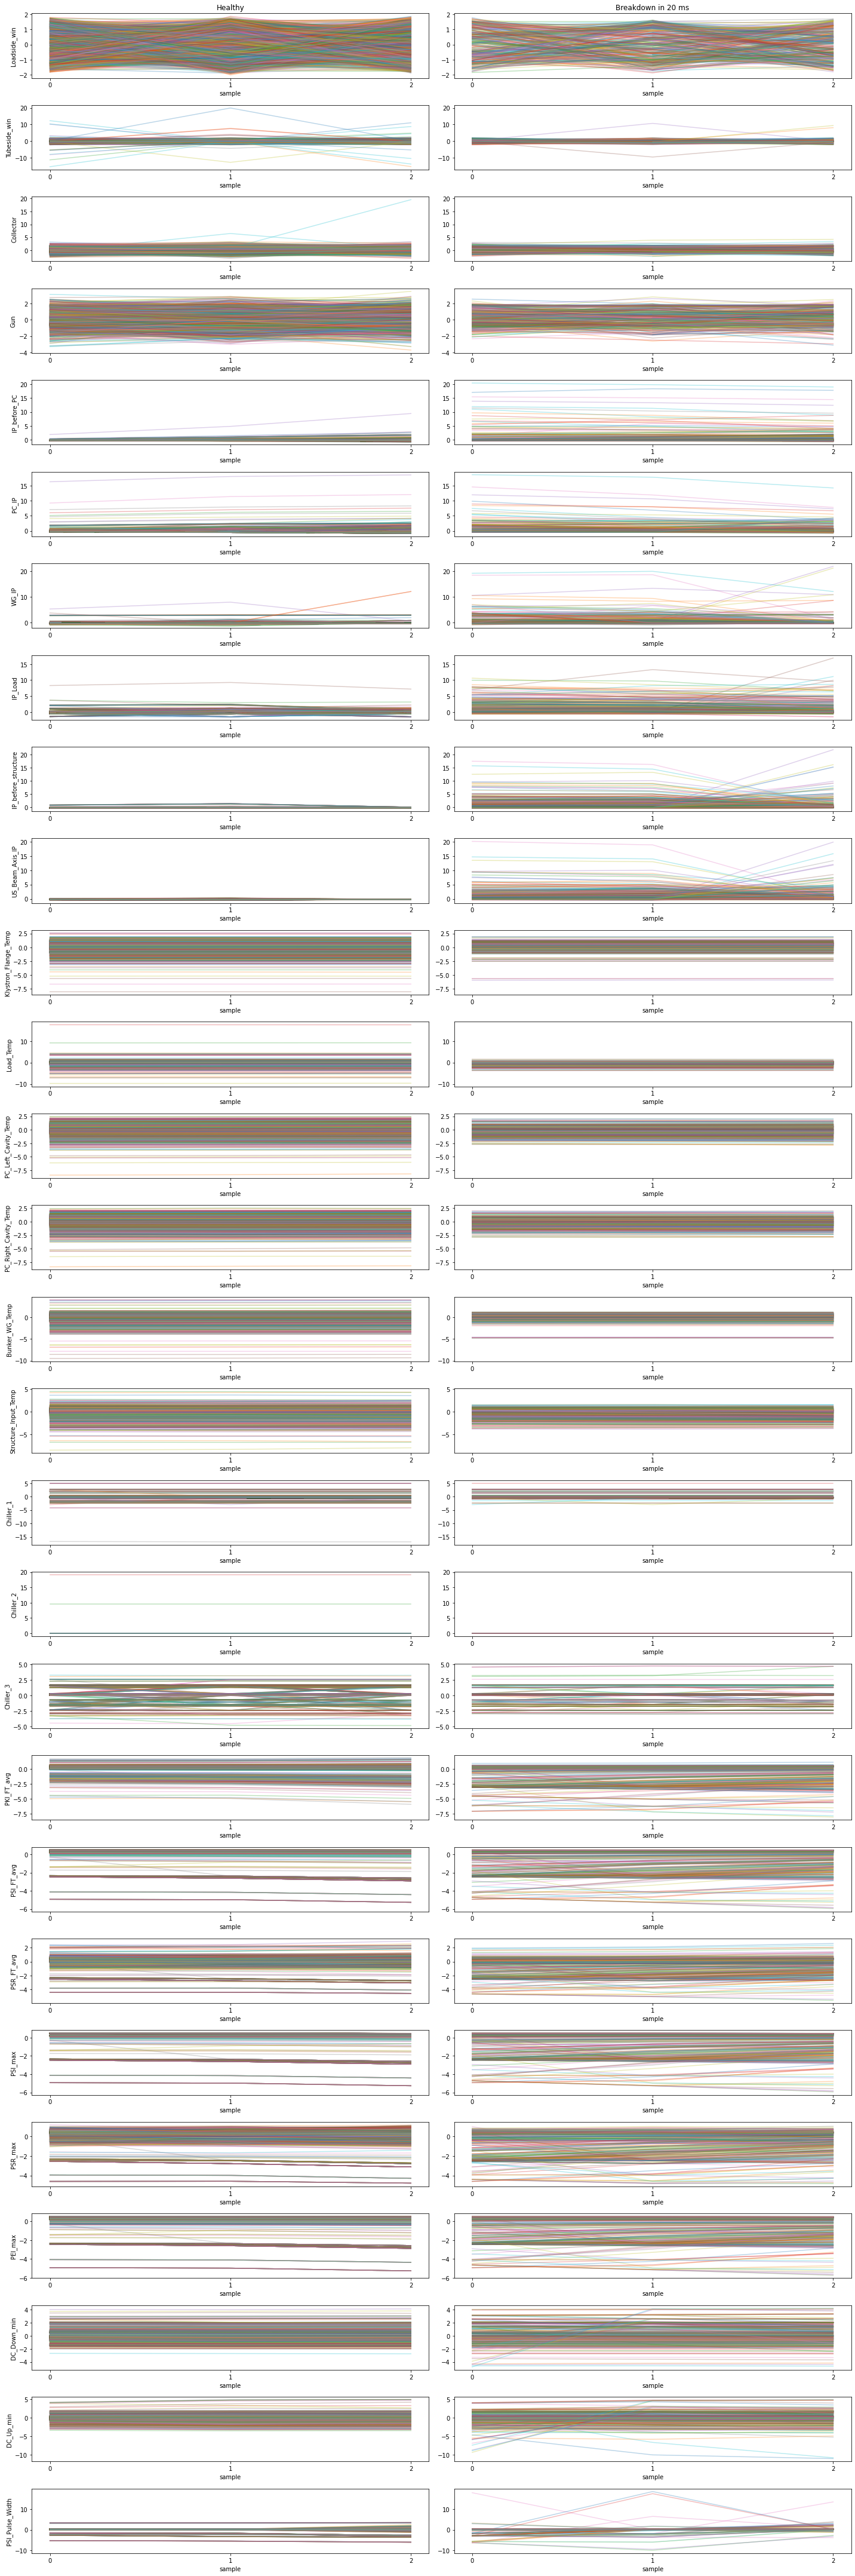

In [3]:
n_features = len(train.X.feature)

fig, ax = plt.subplots(n_features,2, figsize=(20,60))
for i in range(n_features):
    ax[i, 0].plot(train.X[train.y.values.argmax(axis=1) == 0][:,:,i].values.T, alpha=0.3)
    ax[i, 0].set_xlabel("sample")
    ax[i, 0].set_ylabel(train.X.feature[i].values)
    ax[i, 0].set_xticks([0, 1, 2])
    ax[i, 1].plot(train.X[train.y.values.argmax(axis=1) == 1][:,:,i].values.T, alpha=0.3)
    ax[i, 1].set_xlabel("sample")
    ax[i, 1].set_xticks([0, 1, 2])
    bottom0, top0 = ax[i, 0].set_ylim()
    bottom1, top1 = ax[i, 1].set_ylim()
    ax[i, 0].set_ylim([min([bottom0, bottom1]), max([top0, top1])])
    ax[i, 1].set_ylim([min([bottom0, bottom1]), max([top0, top1])])

ax[0, 0].set_title("Healthy")
ax[0, 1].set_title("Breakdown in 20 ms")
fig.tight_layout()
plt.show()

# Getting data ready for machine learning
Before the data is sent to the machine learning models we need to convert them from xarray DataArrays into standard numpy arrays.
This can be done manually or using the helper function found in the dataset_creator module.

In [4]:
train_numpy, valid_numpy, test_numpy = data_array_to_numpy(train, valid, test)

# Create and Use Classifier Model
To create a classifier model an instance of the `Classifier` class is created.
To do this some hyperparameter settings are needed. These are loaded from a ´.json´ file.
We also need to pass the input shape and the directory to put model outputs.

In [5]:
# Load hyperparameters into dictionary
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

# Create model
clf = Classifier(input_shape=train_numpy.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)

## Fit Model
After the model is created it has to be fitted to the data. This is done using the `fit_classifier` method.
Alternatively if a model already has been trained, the trained weights can be loaded.
It is faster to simply load pretrained weights as training is time-consuming.

In [6]:
# Fit model to training set and validate on validation set
clf.fit_classifier(train_numpy, valid_numpy)

Epoch 1/500
135/135 [==============================] - 4s 27ms/step - loss: 0.3870 - tp: 270.0000 - fp: 211.0000 - tn: 1599.0000 - fn: 80.0000 - accuracy: 0.8653 - precision: 0.5613 - recall: 0.7714 - auc: 0.8988 - val_loss: 0.3443 - val_tp: 36.0000 - val_fp: 58.0000 - val_tn: 511.0000 - val_fn: 14.0000 - val_accuracy: 0.8846 - val_precision: 0.3830 - val_recall: 0.7200 - val_auc: 0.8499
Epoch 2/500
135/135 [==============================] - 2s 17ms/step - loss: 0.2436 - tp: 302.0000 - fp: 66.0000 - tn: 1744.0000 - fn: 48.0000 - accuracy: 0.9472 - precision: 0.8207 - recall: 0.8629 - auc: 0.9472 - val_loss: 0.3161 - val_tp: 33.0000 - val_fp: 29.0000 - val_tn: 540.0000 - val_fn: 17.0000 - val_accuracy: 0.9263 - val_precision: 0.5323 - val_recall: 0.6600 - val_auc: 0.8228
Epoch 3/500
135/135 [==============================] - 2s 15ms/step - loss: 0.1989 - tp: 307.0000 - fp: 46.0000 - tn: 1764.0000 - fn: 43.0000 - accuracy: 0.9588 - precision: 0.8697 - recall: 0.8771 - auc: 0.9662 - val_l

Epoch 22/500
135/135 [==============================] - 7s 53ms/step - loss: 0.0025 - tp: 350.0000 - fp: 2.0000 - tn: 1808.0000 - fn: 0.0000e+00 - accuracy: 0.9991 - precision: 0.9943 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.3393 - val_tp: 38.0000 - val_fp: 67.0000 - val_tn: 502.0000 - val_fn: 12.0000 - val_accuracy: 0.8734 - val_precision: 0.3619 - val_recall: 0.7600 - val_auc: 0.8255
Epoch 23/500
135/135 [==============================] - 2s 16ms/step - loss: 0.0022 - tp: 350.0000 - fp: 2.0000 - tn: 1808.0000 - fn: 0.0000e+00 - accuracy: 0.9991 - precision: 0.9943 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.3201 - val_tp: 37.0000 - val_fp: 71.0000 - val_tn: 498.0000 - val_fn: 13.0000 - val_accuracy: 0.8654 - val_precision: 0.3426 - val_recall: 0.7400 - val_auc: 0.8280
Epoch 24/500
135/135 [==============================] - 3s 25ms/step - loss: 0.0015 - tp: 350.0000 - fp: 1.0000 - tn: 1809.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.9972 - recall: 1.0000 - auc: 1.0000

Epoch 43/500
135/135 [==============================] - 2s 16ms/step - loss: 6.4084e-05 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.0782 - val_tp: 38.0000 - val_fp: 60.0000 - val_tn: 509.0000 - val_fn: 12.0000 - val_accuracy: 0.8846 - val_precision: 0.3878 - val_recall: 0.7600 - val_auc: 0.8434
Epoch 44/500
135/135 [==============================] - 2s 14ms/step - loss: 3.9107e-05 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.1103 - val_tp: 38.0000 - val_fp: 60.0000 - val_tn: 509.0000 - val_fn: 12.0000 - val_accuracy: 0.8846 - val_precision: 0.3878 - val_recall: 0.7600 - val_auc: 0.8432
Epoch 45/500
135/135 [==============================] - 2s 14ms/step - loss: 3.2347e-05 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - reca

135/135 [==============================] - 2s 12ms/step - loss: 2.6610e-06 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5266 - val_tp: 38.0000 - val_fp: 58.0000 - val_tn: 511.0000 - val_fn: 12.0000 - val_accuracy: 0.8878 - val_precision: 0.3958 - val_recall: 0.7600 - val_auc: 0.8438
Epoch 64/500
135/135 [==============================] - 1s 10ms/step - loss: 2.3928e-06 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5398 - val_tp: 38.0000 - val_fp: 58.0000 - val_tn: 511.0000 - val_fn: 12.0000 - val_accuracy: 0.8878 - val_precision: 0.3958 - val_recall: 0.7600 - val_auc: 0.8440
Epoch 65/500
135/135 [==============================] - 1s 10ms/step - loss: 2.1563e-06 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

135/135 [==============================] - 2s 12ms/step - loss: 3.8407e-07 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.8397 - val_tp: 38.0000 - val_fp: 55.0000 - val_tn: 514.0000 - val_fn: 12.0000 - val_accuracy: 0.8926 - val_precision: 0.4086 - val_recall: 0.7600 - val_auc: 0.8451
Epoch 84/500
135/135 [==============================] - 2s 13ms/step - loss: 3.5093e-07 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.8530 - val_tp: 38.0000 - val_fp: 55.0000 - val_tn: 514.0000 - val_fn: 12.0000 - val_accuracy: 0.8926 - val_precision: 0.4086 - val_recall: 0.7600 - val_auc: 0.8451
Epoch 85/500
135/135 [==============================] - 2s 18ms/step - loss: 3.2144e-07 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

135/135 [==============================] - 2s 13ms/step - loss: 1.0000e-07 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.0552 - val_tp: 38.0000 - val_fp: 54.0000 - val_tn: 515.0000 - val_fn: 12.0000 - val_accuracy: 0.8942 - val_precision: 0.4130 - val_recall: 0.7600 - val_auc: 0.8460
Epoch 104/500
135/135 [==============================] - 2s 14ms/step - loss: 9.5257e-08 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.0645 - val_tp: 38.0000 - val_fp: 54.0000 - val_tn: 515.0000 - val_fn: 12.0000 - val_accuracy: 0.8942 - val_precision: 0.4130 - val_recall: 0.7600 - val_auc: 0.8460
Epoch 105/500
135/135 [==============================] - 2s 14ms/step - loss: 8.9250e-08 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 16ms/step - loss: 3.1137e-08 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.2389 - val_tp: 38.0000 - val_fp: 54.0000 - val_tn: 515.0000 - val_fn: 12.0000 - val_accuracy: 0.8942 - val_precision: 0.4130 - val_recall: 0.7600 - val_auc: 0.8464
Epoch 124/500
135/135 [==============================] - 2s 18ms/step - loss: 2.8947e-08 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.2515 - val_tp: 38.0000 - val_fp: 54.0000 - val_tn: 515.0000 - val_fn: 12.0000 - val_accuracy: 0.8942 - val_precision: 0.4130 - val_recall: 0.7600 - val_auc: 0.8455
Epoch 125/500
135/135 [==============================] - 2s 15ms/step - loss: 2.7289e-08 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 14ms/step - loss: 8.0972e-09 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.4224 - val_tp: 38.0000 - val_fp: 54.0000 - val_tn: 515.0000 - val_fn: 12.0000 - val_accuracy: 0.8942 - val_precision: 0.4130 - val_recall: 0.7600 - val_auc: 0.8375
Epoch 144/500
135/135 [==============================] - 2s 14ms/step - loss: 7.7679e-09 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.4253 - val_tp: 38.0000 - val_fp: 54.0000 - val_tn: 515.0000 - val_fn: 12.0000 - val_accuracy: 0.8942 - val_precision: 0.4130 - val_recall: 0.7600 - val_auc: 0.8375
Epoch 145/500
135/135 [==============================] - 2s 14ms/step - loss: 7.4000e-09 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 14ms/step - loss: 3.5462e-09 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.5083 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8370
Epoch 164/500
135/135 [==============================] - 2s 14ms/step - loss: 3.3486e-09 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.5129 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8370
Epoch 165/500
135/135 [==============================] - 2s 15ms/step - loss: 3.2884e-09 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 15ms/step - loss: 9.2206e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.5803 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8383
Epoch 184/500
135/135 [==============================] - 2s 13ms/step - loss: 8.8913e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.5842 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8383
Epoch 185/500
135/135 [==============================] - 2s 14ms/step - loss: 8.8913e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 15ms/step - loss: 4.2810e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.6303 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8383
Epoch 204/500
135/135 [==============================] - 2s 14ms/step - loss: 3.9517e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.6324 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8383
Epoch 205/500
135/135 [==============================] - 2s 14ms/step - loss: 3.9517e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 14ms/step - loss: 2.3052e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.6627 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8386
Epoch 224/500
135/135 [==============================] - 2s 14ms/step - loss: 2.3052e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.6645 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8386
Epoch 225/500
135/135 [==============================] - 2s 14ms/step - loss: 1.9758e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 14ms/step - loss: 1.3172e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.6892 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8383
Epoch 244/500
135/135 [==============================] - 2s 15ms/step - loss: 1.3172e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.6902 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8383
Epoch 245/500
135/135 [==============================] - 2s 14ms/step - loss: 1.3172e-10 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7039 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8383
Epoch 264/500
135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7046 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8383
Epoch 265/500
135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 13ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7142 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 284/500
135/135 [==============================] - 2s 12ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7150 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 285/500
135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 13ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7229 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 304/500
135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7230 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 305/500
135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7299 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 324/500
135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7300 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 325/500
135/135 [==============================] - 2s 14ms/step - loss: 3.2931e-11 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 13ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7375 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 344/500
135/135 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7378 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 345/500
135/135 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7452 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 364/500
135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7456 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 365/500
135/135 [==============================] - 2s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7512 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 384/500
135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7514 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 385/500
135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7566 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 404/500
135/135 [==============================] - 2s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7568 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 405/500
135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7616 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 424/500
135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7617 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 425/500
135/135 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7661 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 444/500
135/135 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7663 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 445/500
135/135 [==============================] - 2s 11ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7705 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 464/500
135/135 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7706 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 465/500
135/135 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

135/135 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7746 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 484/500
135/135 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7747 - val_tp: 38.0000 - val_fp: 53.0000 - val_tn: 516.0000 - val_fn: 12.0000 - val_accuracy: 0.8958 - val_precision: 0.4176 - val_recall: 0.7600 - val_auc: 0.8377
Epoch 485/500
135/135 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 350.0000 - fp: 0.0000e+00 - tn: 1810.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 

## Make Prediction
When the model has been fitted to the data, it can be used to make predictions.
Here the prediction is done on the kept out test set using the `predict` method.

In [7]:
y_pred = clf.model.predict(x=test_numpy.X)
y_pred

array([[1.0000000e+00, 1.3953594e-24],
       [1.0000000e+00, 4.2909858e-22],
       [1.0000000e+00, 5.5482657e-23],
       ...,
       [1.0000000e+00, 1.2911894e-26],
       [1.0000000e+00, 1.1879607e-36],
       [1.0000000e+00, 2.0877620e-28]], dtype=float32)

## Evaluate Model
To evaluate the performance of the model, the `evaluate` method can be used.

In [9]:
# eval classifier
results = clf.model.evaluate(x=test_numpy.X, y=test_numpy.y, return_dict=True, batch_size=len(test_numpy.X))
pd.DataFrame.from_dict(results, orient='index').T

1/1 [==============================] - 0s 4ms/step - loss: 2.3424 - tp: 59.0000 - fp: 12.0000 - tn: 571.0000 - fn: 18.0000 - accuracy: 0.9545 - precision: 0.8310 - recall: 0.7662 - auc: 0.8746


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc
0,2.34237,59.0,12.0,571.0,18.0,0.954545,0.830986,0.766234,0.874596


# Explanation
After training the model we now wish to explain the predictions of the model.
This can be done using explainers such as the SHAP gradient explainer.

## Make prediction
To explain a prediction we first make predictions on the test set

In [10]:
y_pred = clf.model.predict(x=test_numpy.X)

In [11]:
type(clf.model)

tensorflow.python.keras.engine.functional.Functional

We then use `explain_samples` to explain the samples.
In this example we use the SHAP gradient explainer.

In [12]:
is_correct_classification = (y_pred.argmax(axis=1) == test_numpy.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                    model=clf.model,
                                    X_reference=train_numpy.X,
                                    X_to_explain=test_numpy.X[is_correct_classification, :, :])

Using TensorFlow backend.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualization of explanations
To explain which features are most important for the explanation, 
we can take the global mean of the shap values for each feature. 
To visualize the explanation we can plot this in a barplot. 

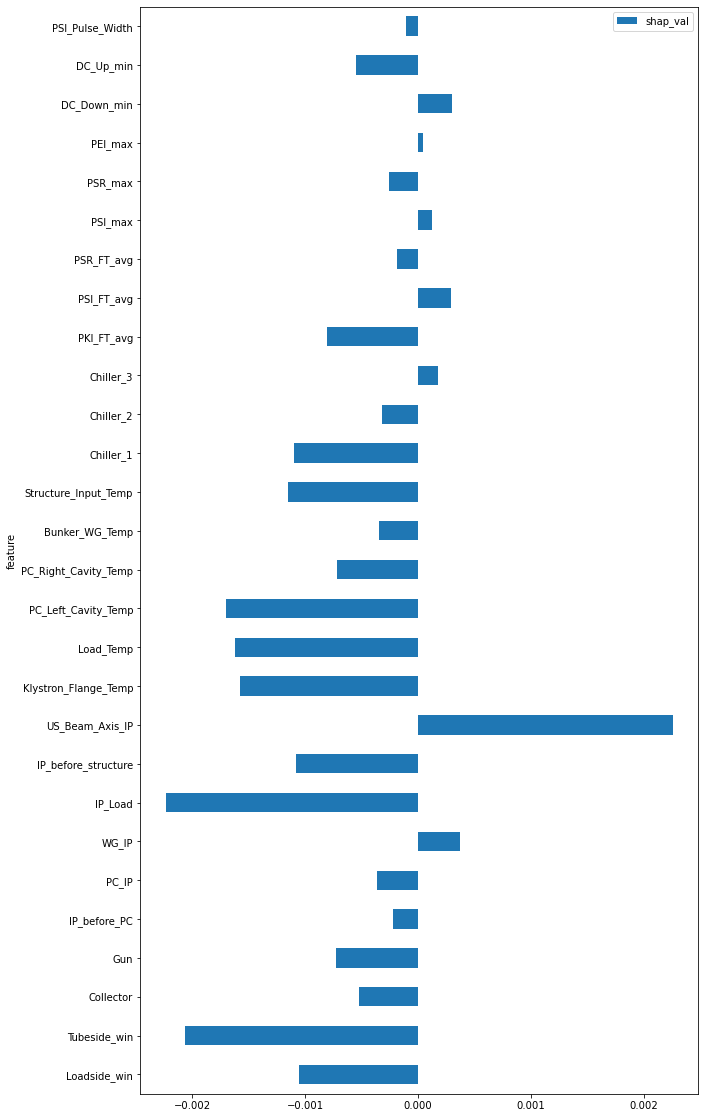

In [13]:
ex_global = np.mean(np.mean(ex_classification[1], axis=0), axis=0)
df = pd.DataFrame({'feature': test.X.feature.values, 'shap_val': ex_global})
ax = df.plot.barh(x='feature', y='shap_val', figsize=(10,20))

In order to present the sample explanation we can make a plot of the signal with a coloured overlay.
Here, overlay color is determined by the shap value.